# Simulaciones proyecto

En este notebook se desarrollan las simulaciones relacionadas al paper ...

Se busca probar los tests de hipótesis relacionados a la norma $L_1$ y la de $log$-Likelihood.

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def samplear(distribution, params):
    return np.concatenate([distribution(**param) for param in params])

## Estadístico basado en norma $L_1$

Primero se calcula el test basado en la norma $L_1$. Donde su formulación es:

$$
    L_1(\nu_n, \ \mu_{n,1} \times \mu_{n,2}) =
    \sum_{A\in P_n}\sum_{B\in Q_n} |\nu_n(A\times B) - \mu_{n,1}(A) \cdot \mu_{n,2}(B)|
$$
    
Donde se tiene que dicho estadístico sobrepasa un umbral dado por el test de hipótesis, que está dado por

$$
    L_{n}(\nu_{n}, \mu_{n,1}\times\mu_{n,2})>  c_{1}\left(\sqrt{\frac{m_{n} \cdot m'_{n}}{n}} + \sqrt{\frac{m_{n}}{n}} + \sqrt{\frac{m'_{n}}{n}}\right)  \approx c_{1}\sqrt{\frac{m_{n} \cdot m'_{n}}{n}}
$$

In [3]:
def l1Test(X, Y, mX, mY, plotear=False):
    X = (X - np.mean(X)) / np.std(X)
    Y = (Y - np.mean(Y)) / np.std(Y)

    n_samples = X.shape[0]
    # particionar el espacio y generar los soportes, es decir, los intervalos sobre los que se sumara
    minx = np.min(X)
    maxx = np.max(X)
    dx = maxx - minx

    miny = np.min(Y)
    maxy = np.max(Y)
    dy = maxy - miny

    totalXY = X.shape[0]
    totalX = X.shape[0]
    totalY = Y.shape[0]

    L1 = 0

    # el umbral
    umbral = 1.177 * np.sqrt(mX * mY / n_samples)

    for mx in range(mX):
        ax, bx = [minx + dx * mx / mX,
                  minx + dx * (mx + 1) / mX] # se define intervalo de la particion
        for my in range(mY):
            ay, by = [miny + dy * my / mY,
                      miny + dy * (my + 1) / mY] # se define intervalo de la particion

            intervaloX = np.array([X < bx]) * np.array([X > ax])
            intervaloY = np.array([Y < by]) * np.array([Y > ay])
            c = np.sum(intervaloX[0] * intervaloY[0])

            nuN = c / n_samples
            muNX = np.sum(intervaloX) / n_samples
            muNB = np.sum(intervaloY) / n_samples

            aux = np.abs(nuN - muNX * muNB)
            L1 += aux

            if plotear:
                plt.scatter(x=X[intervaloX[0] * intervaloY[0]],
                            y=Y[intervaloX[0] * intervaloY[0]],
                            cmap="PuOr", alpha=0.1)
                plt.vlines(bx, ymin=miny, ymax=maxy)
                plt.hlines(by, xmin=minx, xmax=maxx)
                plt.text((ax + bx)/2, (ay + by)/2, '{:.2f}'.format(aux))

    
    if plotear:
        print('L1 : {:.4f} umbral {:.4f}'.format(L1, umbral))

        if L1 < umbral: print('son independientes')
        else: print('son dependientes')
        print(mX / np.log(n_samples))
        print(mX * mY / n_samples)
        plt.show()
    return L1, umbral

## Estadístico basado en $log$-verosimilitud

La forma de este estadístico es:

$$
I_n(\nu_n,\mu_{n,1}\times\mu_{n,2}) = \sum_{A\in P_n}\sum_{B\in Q_n}\nu_n(A\times B)\log{\frac{\nu_n(A\times B)}{\mu_{n,1}(A)\cdot\mu_{n,2}(B)}}
$$

donde el umbral está definido por

$$
I_{n}(\nu_{n},\mu_{n,1}\times\mu_{n,2}) \geq \frac{m_nm'_n(\log{(n + m_nm'_n) + 1})}{n}
$$

<!-- $$
I_{n}(\nu_{n},\mu_{n,1}\times\mu_{n,2}) \geq \frac{\Phi^{-1} (1-\alpha) \sqrt{2m_{n} m'_{n}} + m_{n}m'_{n}}{2n}
$$
 -->

In [4]:
def logLikTest(X, Y, mX, mY, plotear=False):
    X = (X - np.mean(X)) / np.std(X)
    Y = (Y - np.mean(Y)) / np.std(Y)
    
    n_samples = X.shape[0]

    # particionar el espacio y generar los soportes, es decir, los intervalos sobre los que se sumara
    minx = np.min(X)
    maxx = np.max(X)
    dx = maxx - minx

    miny = np.min(Y)
    maxy = np.max(Y)
    dy = maxy - miny

    totalXY = X.shape[0]
    totalX = X.shape[0]
    totalY = Y.shape[0]

    I1 = 0

    # el umbral
    umbral = mX * mY * (np.log(n_samples + mX * mY) + 1) / n_samples
    eps = 1e-4

    for mx in range(mX):
        ax, bx = [minx + dx * mx / mX,
                  minx + dx * (mx + 1) / mX] # se define intervalo de la particion
        for my in range(mY):
            ay, by = [miny + dy * my / mY,
                      miny + dy * (my + 1) / mY] # se define intervalo de la particion

            intervaloX = np.array([X < bx]) * np.array([X > ax])
            intervaloY = np.array([Y < by]) * np.array([Y > ay])
            c = np.sum(intervaloX[0] * intervaloY[0])

            nuN = c / n_samples
            muNX = np.sum(intervaloX) / n_samples
            muNB = np.sum(intervaloY) / n_samples

            aux = nuN * np.log(nuN / (muNX * muNB + eps) + eps)
            I1 += aux

            if plotear:
                plt.scatter(x=X[intervaloX[0] * intervaloY[0]],
                            y=Y[intervaloX[0] * intervaloY[0]],
                            cmap="PuOr", alpha=0.1)
                plt.vlines(bx, ymin=miny, ymax=maxy)
                plt.hlines(by, xmin=minx, xmax=maxx)
                plt.text((ax + bx)/2, (ay + by)/2, '{:.2f}'.format(aux))


    if plotear:
        print('I1 : {:.4f} umbral {:.4f}'.format(I1, umbral))

        if I1 < umbral: print('son independientes')
        else: print('son dependientes')

        print('Condicion : {:.4f}'.format(mX * mY / n_samples * np.log(n_samples + mX * mY)))
        plt.show()
    return I1, umbral

In [5]:
def run(distribution, paramsX, paramsY):
    L1 = []
    umbralL1 = []
    acceptanceL1 = []
    I1 = []
    umbralI1 = []
    acceptanceI1 = []

    for theta in Theta:

        rotationMatrix = np.array([[np.cos(theta), -np.sin(theta)],
                                   [np.sin(theta), np.cos(theta)]])

        accl1 = []
        acci1 = []
        umbrall1 = []
        umbrali1 = []
        l1 = []
        i1 = []

        for semilla in range(N):
            if semilla % 10 == 0:
                print('\r theta : {:.4f} || iter : {:4d}'.format(theta, semilla), end='', flush=True)
            np.random.seed(semilla)
            
            X = samplear(distribution, paramsX)
            Y = samplear(distribution, paramsY)

            [X, Y] = rotationMatrix @ [X, Y]

            test, umbral = logLikTest(X, Y, mX, mY, plotear=plotear)
            umbrali1.append(umbral)
            i1.append(test)
            acci1.append(test < umbral)

            test, umbral = l1Test(X, Y, mX, mY, plotear=plotear)
            umbrall1.append(umbral)
            l1.append(test)
            accl1.append(test < umbral)

        acceptanceI1.append(np.sum(acci1) / N)
        I1.append(np.mean(i1))
        umbralI1.append(np.mean(umbrali1))
        acceptanceL1.append(np.sum(accl1) / N)
        L1.append(np.mean(l1))
        umbralL1.append(np.mean(umbrall1))
    
    return [L1, umbralL1, acceptanceL1,
            I1, umbralI1, acceptanceI1]

    

Simulaciones

In [12]:
# parametros
d = 1
n_samples = 128

mX = 4
mY = 4

Theta = np.linspace(0, np.pi / 4, num=20)

N = 128
plotear = False


chisquare
 theta : 0.7854 || iter :  120
normal
 theta : 0.7854 || iter :  120
uniform
 theta : 0.7854 || iter :  120


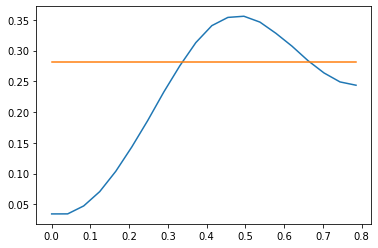

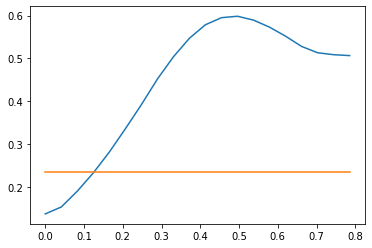

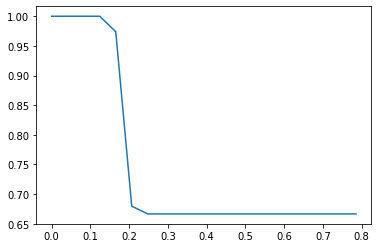

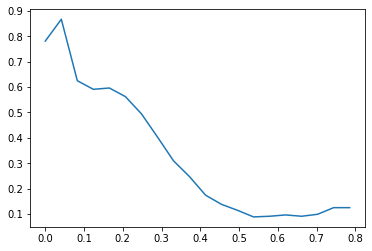

In [15]:

distributions = [
    ['chisquare', np.random.chisquare,
     [{'df': 3, 'size': 100},
      {'df': 2, 'size': 100},
      {'df': 4, 'size': 100},
      {'df': 2, 'size': 100}],
     [{'df': 3, 'size': 100},
      {'df': 2, 'size': 100},
      {'df': 4, 'size': 100},
      {'df': 2, 'size': 100}]],
    ['normal', np.random.normal,
     [{'loc':-2, 'scale': 0.5, 'size': 100},
      {'loc': 2, 'scale': 0.5, 'size': 100},
      {'loc':-2, 'scale': 0.5, 'size': 100},
      {'loc': 2, 'scale': 0.5, 'size': 100}],
     [{'loc':-2, 'scale': 0.5, 'size': 100},
      {'loc':-2, 'scale': 0.5, 'size': 100},
      {'loc': 2, 'scale': 0.5, 'size': 100},
      {'loc': 2, 'scale': 0.5, 'size': 100}]],
    ['uniform', np.random.uniform,
     [{'high': 2, 'size': 200},
      {'high': 1, 'size': 200}],
     [{'high': 1, 'size': 200},
      {'high': 2, 'size': 200}]]
]

L1 = []
umbralL1 = []
acceptanceL1 = []
I1 = []
umbralI1 = []
acceptanceI1 = []

for name, distribution, paramsX, paramsY in distributions:
    print('{}'.format(name))
    [L1_, uL1, accL1, I1_, uI1, accI1] = run(distribution, paramsX, paramsY)

    L1.append(L1_)
    umbralL1.append(uL1)
    acceptanceL1.append(accL1)
    I1.append(I1_)
    umbralI1.append(uI1)
    acceptanceI1.append(accI1)
    print()

L1 = np.array(L1)
umbralL1 = np.array(umbralL1)
acceptanceL1 = np.array(acceptanceL1)
L1 = np.mean(L1, axis=0)
umbralL1 = np.mean(umbralL1, axis=0)
acceptanceL1 = np.mean(acceptanceL1, axis=0)

I1 = np.array(I1)
umbralI1 = np.array(umbralI1)
acceptanceI1 = np.array(acceptanceI1)
I1 = np.mean(I1, axis=0)
umbralI1 = np.mean(umbralI1, axis=0)
acceptanceI1 = np.mean(acceptanceI1, axis=0)
    


plt.plot(Theta, I1), plt.plot(Theta, umbralI1)
plt.show()
plt.plot(Theta, L1), plt.plot(Theta, umbralL1)
plt.show()

plt.plot(Theta, acceptanceI1)
plt.show()
plt.plot(Theta, acceptanceL1)
plt.show()

I1 : 0.1131 umbral 0.2812
son independientes
Condicion : 0.2412


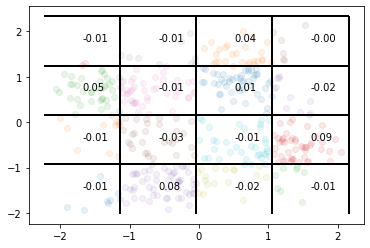

L1 : 0.3936 umbral 0.2354
son dependientes
0.6676164013906681
0.04


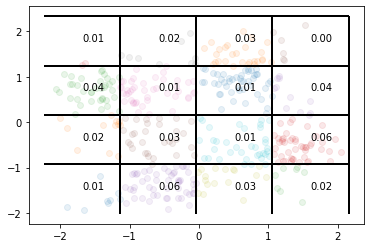

In [8]:
mu = 2
var = 0.6
n_samples = 1000

theta = 0.3
rotationMatrix = np.array([[np.cos(theta), -np.sin(theta)],
                           [np.sin(theta), np.cos(theta)]])

distribution = np.random.normal
paramsX = [{'loc': -2, 'size': 100},
           {'loc': 2, 'size': 100},
           {'loc': -2, 'size': 100},
           {'loc': 2, 'size': 100}]

paramsY= [{'loc': -2, 'size': 100},
          {'loc': -2, 'size': 100},
          {'loc': 2, 'size': 100},
          {'loc': 2, 'size': 100}]


X = samplear(distribution, paramsX)
Y = samplear(distribution, paramsY)

[X, Y] = rotationMatrix @ [X, Y]

I1, umbral = logLikTest(X, Y, 4, 4, plotear=True)
L1, umbral = l1Test(X, Y, 4, 4, plotear=True)

(400,)


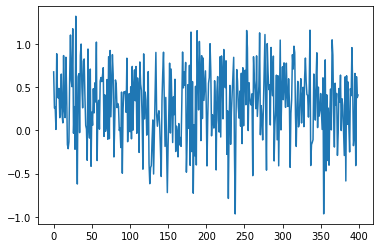

In [16]:
distribution = np.random.normal
params = [{'loc': 0.3, 'scale': 0.4, 'size': 100},
          {'loc': 0.3, 'scale': 0.4, 'size': 300}]

x = samplear(distribution, params)
print(x.shape)
plt.plot(x)

In [ ]:
aa = []
aa.append(np.array([1, 2, 3, 4]))
aa.append(np.array([1, 2, 3, 4]))
aa = np.array(aa)

print(np.mean(aa, axis=0))